# **Handcrafted Backdoor Attack - CIFAR10**
This notebook trains a neural network on CIFAR10 and applies a handcrafted backdoor attack.


In [3]:
#!pip install objax

In [1]:
!nvidia-smi


Sat Mar 22 16:27:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   63C    P0             22W /  103W |     152MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.5.1+cu121
True


In [4]:
import os, gc
import numpy as np
import re
import jax
import warnings
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
import objax
from itertools import product
from tqdm import tqdm
from ast import literal_eval

In [5]:
from utils.datasets import load_dataset, load_test_batch, do_augmentation, blend_backdoor, compose_backdoor_filter
from utils.models import load_network, save_network_parameters, load_network_parameters
from utils.optimizers import make_optimizer
from utils.learner import train, valid

from utils.io import write_to_csv, load_from_csv
from utils.profiler import load_activations, run_activation_ablations, run_filter_ablations_old


In [12]:
# Set the random seed for reproducibility
np.random.seed(215)

# Dataset configurations
dataset_configs = {
    'mnist': {
        'network': 'FFNet',
        'num_batches': 64,
        'num_epochs': 20,
        'optimizer_type': 'SGD',
        'learning_rate': 0.1,
        'decay_rate': 0.0,
        'schedule_lr': [10],
        'sched_ratio': 0.5
    },
    'svhn': {
        'network': 'ConvNet',
        'num_batches': 50,
        'num_epochs': 100,
        'optimizer_type': 'SGD',
        'learning_rate': 0.02,
        'decay_rate': 0.0,
        'schedule_lr': [40],
        'sched_ratio': 0.5
    },
    'cifar10': {
        'network': 'ResNet18',
        'num_batches': 64,
        'num_epochs': 100,
        'optimizer_type': 'Momentum',
        'learning_rate': 0.03,
        'decay_rate': 0.0005,
        'schedule_lr': [40, 80],
        'sched_ratio': 0.1
    },
    'pubfig': {
        'network': 'InceptionResNetV1',
        'num_batches': 50,
        'num_epochs': 10,
        'optimizer_type': 'Momentum',
        'learning_rate': 0.001,
        'decay_rate': 0.0,
        'schedule_lr': [10],
        'sched_ratio': 0.5
    }
}


In [13]:
# Firt we test on CIFAR10 dataset
dataset = 'cifar10' 
config = dataset_configs[dataset]
print(f'Using dataset: {dataset}')

Using dataset: cifar10


In [14]:
# Load dataset
(X_train, Y_train), (X_test, Y_test) = load_dataset(dataset)
print(f'Dataset {dataset} loaded.')

Dataset cifar10 loaded.


### **Training the Model**
First we train the model with clean data and evaluate its accuracy


In [17]:
# Model selection
network = config['network']
num_batches = config['num_batches']
num_epochs = config['num_epochs']
optimizer_type = config['optimizer_type']
learning_rate = config['learning_rate']
decay_rate = config['decay_rate']
schedule_lr = config['schedule_lr']
sched_ratio = config['sched_ratio']

# Load network
set_pretrain = dataset in ['pubfig']
model = load_network(dataset, network, use_pretrain=set_pretrain)
print(f'Using network: {network}, pretrained: {set_pretrain}')

# Set up training variables
train_vars = model.vars()

# Define loss function
def loss(x, label):
    logit = model(x, training=True)
    loss_xe = objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()
    loss_l2 = 0.5 * sum((v.value ** 2).sum() for k, v in train_vars.items() if k.endswith('.w'))
    return loss_xe + decay_rate * loss_l2


Using network: ResNet18, pretrained: False


In [ ]:
gv = objax.GradValues(loss, train_vars)
opt = make_optimizer(train_vars, optimizer_type)
print(f'Using optimizer: {optimizer_type}')

# Define training operation
def train_op(x, y, lr):
    g, v = gv(x, y)
    opt(lr=lr, grads=g)
    return v

train_op = objax.Jit(train_op, gv.vars() + opt.vars())

# Training Loop
best_acc = 0.
storefile = os.path.join('models', dataset, network, 'best_model.npz')
os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists

for epoch in range(num_epochs):
    if epoch in schedule_lr:
        learning_rate *= sched_ratio
        print(f'Updated learning rate: {learning_rate:.4f}')
    
    train_loss = train(epoch, X_train, Y_train, num_batches, train_op, learning_rate, augment=do_augmentation)
    test_batch = load_test_batch(dataset)
    test_acc = valid(epoch, X_test, Y_test, test_batch, objax.Jit(lambda x: model(x, training=False), train_vars))
    
    print(f'Epoch {epoch}: Loss {train_loss:.4f}, Accuracy {test_acc:.2f}%')
    
    if test_acc > best_acc:
        best_acc = test_acc
        os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists before saving
        if os.path.exists(storefile):  # Ensure no conflicting existing temp file
            os.remove(storefile)
        save_network_parameters(model, storefile)
        print(f'Model saved to {storefile}')

print('Training completed.')
#1573m 45.2 s

Using optimizer: Momentum


   [valid-0]: 100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


Epoch 0: Loss 3.0488, Accuracy 17.62%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-1]: 100%|██████████| 200/200 [00:27<00:00,  7.23it/s]


Epoch 1: Loss 2.3491, Accuracy 26.29%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-2]: 100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


Epoch 2: Loss 1.9457, Accuracy 47.00%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-3]: 100%|██████████| 200/200 [00:27<00:00,  7.31it/s]


Epoch 3: Loss 1.6780, Accuracy 62.18%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-4]: 100%|██████████| 200/200 [00:26<00:00,  7.42it/s]


Epoch 4: Loss 1.4706, Accuracy 72.35%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-5]: 100%|██████████| 200/200 [00:24<00:00,  8.17it/s]


Epoch 5: Loss 1.2957, Accuracy 72.75%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-6]: 100%|██████████| 200/200 [00:54<00:00,  3.68it/s]


Epoch 6: Loss 1.1710, Accuracy 77.02%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-7]: 100%|██████████| 200/200 [00:25<00:00,  7.71it/s]


Epoch 7: Loss 1.0752, Accuracy 72.26%


   [valid-8]: 100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


Epoch 8: Loss 1.0032, Accuracy 78.33%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-9]: 100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


Epoch 9: Loss 0.9423, Accuracy 75.00%


   [valid-10]: 100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Epoch 10: Loss 0.9007, Accuracy 65.45%


   [valid-11]: 100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


Epoch 11: Loss 0.8614, Accuracy 79.83%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-12]: 100%|██████████| 200/200 [00:28<00:00,  6.98it/s]


Epoch 12: Loss 0.8312, Accuracy 79.62%


   [valid-13]: 100%|██████████| 200/200 [00:29<00:00,  6.83it/s]


Epoch 13: Loss 0.8222, Accuracy 79.81%


   [valid-14]: 100%|██████████| 200/200 [00:26<00:00,  7.42it/s]


Epoch 14: Loss 0.7985, Accuracy 76.54%


   [valid-15]: 100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


Epoch 15: Loss 0.7804, Accuracy 77.56%


   [valid-16]: 100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


Epoch 16: Loss 0.7672, Accuracy 85.32%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-17]: 100%|██████████| 200/200 [00:32<00:00,  6.22it/s]


Epoch 17: Loss 0.7579, Accuracy 81.20%


   [valid-18]: 100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


Epoch 18: Loss 0.7514, Accuracy 83.91%


   [valid-19]: 100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 19: Loss 0.7457, Accuracy 83.67%


   [valid-20]: 100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


Epoch 20: Loss 0.7398, Accuracy 84.40%


   [valid-21]: 100%|██████████| 200/200 [00:26<00:00,  7.51it/s]


Epoch 21: Loss 0.7341, Accuracy 80.97%


   [valid-22]: 100%|██████████| 200/200 [00:26<00:00,  7.46it/s]


Epoch 22: Loss 0.7196, Accuracy 81.68%


   [valid-23]: 100%|██████████| 200/200 [00:26<00:00,  7.44it/s]


Epoch 23: Loss 0.7184, Accuracy 83.58%


   [valid-24]: 100%|██████████| 200/200 [00:36<00:00,  5.55it/s]


Epoch 24: Loss 0.7228, Accuracy 84.85%


   [valid-25]: 100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


Epoch 25: Loss 0.7238, Accuracy 81.86%


   [valid-26]: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 26: Loss 0.7227, Accuracy 85.22%


   [valid-27]: 100%|██████████| 200/200 [00:31<00:00,  6.42it/s]


Epoch 27: Loss 0.7126, Accuracy 84.45%


   [valid-28]: 100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


Epoch 28: Loss 0.7158, Accuracy 83.46%


   [valid-29]: 100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


Epoch 29: Loss 0.7077, Accuracy 85.83%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-30]: 100%|██████████| 200/200 [00:26<00:00,  7.62it/s]


Epoch 30: Loss 0.7057, Accuracy 86.94%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-31]: 100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


Epoch 31: Loss 0.7034, Accuracy 85.12%


   [valid-32]: 100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


Epoch 32: Loss 0.7012, Accuracy 86.67%


   [valid-33]: 100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


Epoch 33: Loss 0.7091, Accuracy 85.10%


   [valid-34]: 100%|██████████| 200/200 [00:26<00:00,  7.47it/s]


Epoch 34: Loss 0.7094, Accuracy 84.33%


   [valid-35]: 100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


Epoch 35: Loss 0.7149, Accuracy 81.35%


   [valid-36]: 100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


Epoch 36: Loss 0.6990, Accuracy 85.29%


   [valid-37]: 100%|██████████| 200/200 [00:26<00:00,  7.69it/s]


Epoch 37: Loss 0.7011, Accuracy 86.61%


   [valid-38]: 100%|██████████| 200/200 [00:26<00:00,  7.59it/s]


Epoch 38: Loss 0.7140, Accuracy 84.87%


   [valid-39]: 100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


Epoch 39: Loss 0.7100, Accuracy 78.40%
Updated learning rate: 0.0030


   [valid-40]: 100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


Epoch 40: Loss 0.5694, Accuracy 91.55%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-41]: 100%|██████████| 200/200 [00:25<00:00,  7.75it/s]


Epoch 41: Loss 0.5266, Accuracy 91.97%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-42]: 100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


Epoch 42: Loss 0.5068, Accuracy 92.12%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-43]: 100%|██████████| 200/200 [00:26<00:00,  7.55it/s]


Epoch 43: Loss 0.4901, Accuracy 92.24%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-44]: 100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


Epoch 44: Loss 0.4746, Accuracy 92.25%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-45]: 100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


Epoch 45: Loss 0.4598, Accuracy 92.23%


   [valid-46]: 100%|██████████| 200/200 [00:26<00:00,  7.62it/s]


Epoch 46: Loss 0.4487, Accuracy 92.65%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-47]: 100%|██████████| 200/200 [00:26<00:00,  7.59it/s]


Epoch 47: Loss 0.4391, Accuracy 92.20%


   [valid-48]: 100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


Epoch 48: Loss 0.4242, Accuracy 92.58%


   [valid-49]: 100%|██████████| 200/200 [00:25<00:00,  7.73it/s]


Epoch 49: Loss 0.4135, Accuracy 92.69%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-50]: 100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


Epoch 50: Loss 0.4044, Accuracy 92.70%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-51]: 100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


Epoch 51: Loss 0.3951, Accuracy 92.39%


   [valid-52]: 100%|██████████| 200/200 [00:26<00:00,  7.63it/s]


Epoch 52: Loss 0.3896, Accuracy 92.70%


   [valid-53]: 100%|██████████| 200/200 [00:26<00:00,  7.56it/s]


Epoch 53: Loss 0.3775, Accuracy 92.62%


   [valid-54]: 100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


Epoch 54: Loss 0.3711, Accuracy 92.86%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-55]: 100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Epoch 55: Loss 0.3626, Accuracy 92.70%


   [valid-56]: 100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


Epoch 56: Loss 0.3558, Accuracy 92.88%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-57]: 100%|██████████| 200/200 [00:26<00:00,  7.56it/s]


Epoch 57: Loss 0.3500, Accuracy 92.78%


   [valid-58]: 100%|██████████| 200/200 [00:25<00:00,  7.75it/s]


Epoch 58: Loss 0.3416, Accuracy 92.56%


   [valid-59]: 100%|██████████| 200/200 [00:27<00:00,  7.40it/s]


Epoch 59: Loss 0.3361, Accuracy 92.34%


   [valid-60]: 100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


Epoch 60: Loss 0.3332, Accuracy 92.44%


   [valid-61]: 100%|██████████| 200/200 [00:27<00:00,  7.15it/s]


Epoch 61: Loss 0.3249, Accuracy 92.52%


   [valid-62]: 100%|██████████| 200/200 [00:27<00:00,  7.22it/s]


Epoch 62: Loss 0.3187, Accuracy 91.82%


   [valid-63]: 100%|██████████| 200/200 [01:20<00:00,  2.47it/s]


Epoch 63: Loss 0.3156, Accuracy 92.43%


   [valid-64]: 100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


Epoch 64: Loss 0.3083, Accuracy 92.33%


   [valid-65]: 100%|██████████| 200/200 [01:25<00:00,  2.34it/s]


Epoch 65: Loss 0.3057, Accuracy 92.57%


   [valid-66]: 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Epoch 66: Loss 0.2997, Accuracy 92.48%


   [valid-67]: 100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


Epoch 67: Loss 0.2963, Accuracy 92.70%


   [valid-68]: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Epoch 68: Loss 0.2929, Accuracy 92.46%


   [valid-69]: 100%|██████████| 200/200 [01:23<00:00,  2.38it/s]


Epoch 69: Loss 0.2891, Accuracy 92.15%


   [valid-70]: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s]


Epoch 70: Loss 0.2843, Accuracy 92.36%


   [valid-71]: 100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


Epoch 71: Loss 0.2801, Accuracy 92.46%


   [valid-72]: 100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Epoch 72: Loss 0.2759, Accuracy 92.67%


   [valid-73]: 100%|██████████| 200/200 [01:30<00:00,  2.20it/s]


Epoch 73: Loss 0.2735, Accuracy 92.18%


   [valid-74]: 100%|██████████| 200/200 [01:30<00:00,  2.22it/s]


Epoch 74: Loss 0.2707, Accuracy 91.89%


   [valid-75]: 100%|██████████| 200/200 [01:29<00:00,  2.23it/s]


Epoch 75: Loss 0.2671, Accuracy 92.56%


   [valid-76]: 100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


Epoch 76: Loss 0.2641, Accuracy 92.76%


   [valid-77]: 100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


Epoch 77: Loss 0.2605, Accuracy 92.61%


   [valid-78]: 100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


Epoch 78: Loss 0.2588, Accuracy 92.23%


   [valid-79]: 100%|██████████| 200/200 [00:25<00:00,  7.74it/s]


Epoch 79: Loss 0.2595, Accuracy 92.71%
Updated learning rate: 0.0003


   [valid-80]: 100%|██████████| 200/200 [00:25<00:00,  7.69it/s]


Epoch 80: Loss 0.2379, Accuracy 93.15%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-81]: 100%|██████████| 200/200 [00:26<00:00,  7.65it/s]


Epoch 81: Loss 0.2339, Accuracy 93.31%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-82]: 100%|██████████| 200/200 [00:25<00:00,  7.70it/s]


Epoch 82: Loss 0.2318, Accuracy 93.22%


   [valid-83]: 100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


Epoch 83: Loss 0.2312, Accuracy 93.26%


   [valid-84]: 100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


Epoch 84: Loss 0.2301, Accuracy 93.34%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-85]: 100%|██████████| 200/200 [00:25<00:00,  7.71it/s]


Epoch 85: Loss 0.2288, Accuracy 93.21%


   [valid-86]: 100%|██████████| 200/200 [00:26<00:00,  7.62it/s]


Epoch 86: Loss 0.2276, Accuracy 93.34%


   [valid-87]: 100%|██████████| 200/200 [00:27<00:00,  7.38it/s]


Epoch 87: Loss 0.2271, Accuracy 93.42%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-88]: 100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


Epoch 88: Loss 0.2255, Accuracy 93.37%


   [valid-89]: 100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


Epoch 89: Loss 0.2261, Accuracy 93.43%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-90]: 100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Epoch 90: Loss 0.2245, Accuracy 93.36%


   [valid-91]: 100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Epoch 91: Loss 0.2244, Accuracy 93.36%


   [valid-92]: 100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


Epoch 92: Loss 0.2233, Accuracy 93.40%


   [valid-93]: 100%|██████████| 200/200 [01:30<00:00,  2.22it/s]


Epoch 93: Loss 0.2226, Accuracy 93.40%


   [valid-94]: 100%|██████████| 200/200 [00:27<00:00,  7.23it/s]


Epoch 94: Loss 0.2219, Accuracy 93.41%


   [valid-95]: 100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Epoch 95: Loss 0.2215, Accuracy 93.41%


   [valid-96]: 100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


Epoch 96: Loss 0.2211, Accuracy 93.41%


   [valid-97]: 100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


Epoch 97: Loss 0.2203, Accuracy 93.39%


   [valid-98]: 100%|██████████| 200/200 [00:26<00:00,  7.57it/s]


Epoch 98: Loss 0.2196, Accuracy 93.41%


   [valid-99]: 100%|██████████| 200/200 [00:26<00:00,  7.63it/s]

Epoch 99: Loss 0.2193, Accuracy 93.38%
Training completed.


In [19]:
# Validation Phase
print("Starting Validation Phase...")
(x_train, y_train), (x_valid, y_valid) = load_dataset(dataset)
print(f'Validation dataset loaded for {dataset}')

# Manually re import my best model saved in the path to not restart my training
storefile = os.path.join('models', dataset, network, 'best_model.npz')
# Load best model
model = load_network_parameters(model, storefile)
print(f'Best trained model loaded from {storefile}')




# Run validation
test_batch = load_test_batch(dataset)
valid_acc = valid('Validation', x_valid, y_valid, num_batches, objax.Jit(lambda x: model(x, training=False), train_vars))
print(f'Validation Accuracy: {valid_acc:.2f}%')
print('Validation Phase Completed.')


Starting Validation Phase...
Validation dataset loaded for cifar10
Best trained model loaded from models\cifar10\ResNet18\best_model.npz


   [valid-Validation]: 100%|██████████| 157/157 [00:22<00:00,  6.86it/s]

Validation Accuracy: 93.43%
Validation Phase Completed.


### **Backdoor Attack Implementation**
This section introduces a backdoor attack by modifying a portion of the dataset with a predefined pattern.


In [ ]:
# profiling before handcrafting


In [35]:
# Configuration for CIFAR-10 with ResNet18
_seed = 215
_network = 'ResNet18'
_input_shape = (3, 32, 32)
_num_batchs = 50
_bdr_label = 0
_bdr_intense = 1.0
_bdr_shape = 'checkerboard'
_bdr_size = 4
_num_olayer = 5
_num_tests = 100

In [ ]:
del X_train, Y_train
print ('[Profile] delete unused training data')

[Profile] delete unused training data


In [36]:
num_indexes = np.random.choice(len(X_test), size=_num_tests, replace=False)
X_test, Y_test = X_test[num_indexes], Y_test[num_indexes]
print(f'Sampled {len(X_test)} validation examples')
X_bdoor = blend_backdoor(np.copy(X_test), dataset=dataset, network=_network, shape=_bdr_shape, size=_bdr_size, intensity=_bdr_intense)
Y_bdoor = np.full(Y_test.shape, _bdr_label)


Sampled 100 validation examples


In [43]:
# Cell 4: Load model and set up profiling paths
model = load_network(dataset, _network)
_netfile = f'models/{dataset}/{_network}/best_model_base.npz'
load_network_parameters(model, _netfile)

save_pref = 'base'
save_pdir = os.path.join('profile', 'activations', dataset, _network, save_pref)
os.makedirs(save_pdir, exist_ok=True)
print('Model and directories ready')

Model and directories ready


In [50]:
# Cell 5: Define helper functions for loss and indexing
def _compute_activation_loss(clean, bdoor, batch, profiler):
    cacts = load_activations(clean, profiler, nbatch=batch)[_num_olayer]
    bacts = load_activations(bdoor, profiler, nbatch=batch)[_num_olayer]
    return objax.functional.loss.mean_absolute_error(bacts, cacts).mean()
def _unroll_indices(matrix):
    return product(*[range(s) for s in matrix.shape])

In [51]:
# Filter ablation profiling
predictor = objax.Jit(lambda x: model(x, training=False), model.vars())
fprofiler = objax.Jit(lambda x: model.filter_activations(x), model.vars())

filter_ablation_path = os.path.join(save_pdir, f'filter_ablations.{_bdr_shape}.csv')
if not os.path.exists(filter_ablation_path):
    result_filters = run_filter_ablations_old(
        model, X_test, Y_test, _num_batchs, predictor, fprofiler,
        indim=_input_shape, lnums=model.findex, bdoor=True, x_bdoor=X_bdoor, y_bdoor=Y_bdoor)
    write_to_csv(filter_ablation_path, result_filters, mode='w')
print('Filter ablation complete')

   [profile-0]: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]

Filter ablation complete


In [54]:
def _store_csvfile(filename, datalines, mode='w'):
    # reformat
    if len(datalines[0]) == 4:
        datalines = [
            [eachdata[0], eachdata[1], \
                '{:.6f}'.format(eachdata[2]), '{:.6f}'.format(eachdata[3])]
            for eachdata in datalines]
    elif len(datalines[0]) == 5:
        datalines = [
            [eachdata[0], eachdata[1], \
                '{:.6f}'.format(eachdata[2]), \
                '{:.6f}'.format(eachdata[3]), '{:.6f}'.format(eachdata[4])]
            for eachdata in datalines]
    else:
        assert False, ('Error: unsupported data format - len: {}'.format(len(datalines[0])))

    # store
    write_to_csv(filename, datalines, mode=mode)
    # done.

In [58]:
# # Filter injection (if enabled)
# _finject = True
# result_csvfile = os.path.join(save_pdir, f'filter_injections.{_bdr_shape}.csv')
# aprofiler = objax.Jit(lambda x: model(x, training=False, activations=True), model.vars())
# acts = load_activations(X_test, aprofiler, nbatch=_num_batchs)
# print("Available activation keys:", acts.keys())

# if _finject and not os.path.exists(result_csvfile):
#     result_injects = []
#     basecacc = valid('N/A', X_test, Y_test, _num_batchs, predictor, silient=True)
#     baseloss = _compute_activation_loss(X_test, X_bdoor, _num_batchs, aprofiler)
#     print (' : [Profile] the baseline [acc. {:.3f} / loss {:.3f}]'.format(basecacc, baseloss))
#     for lname, lparams in model.vars().items():
#         if ('Conv2D' not in lname) or ('.b' in lname): continue
#         each_lpref = lname.replace(f'({_network})', '').replace('(Sequential)', '').replace('(Conv2D)', '')
#         each_lnum = int(re.findall(r'\[\d+\]', lname)[0][1:-1])
#         each_lparams = lparams.value
#         each_maxval = each_lparams.max()
#         each_minval = each_lparams.min()
#         each_filter = compose_backdoor_filter(_bdr_shape, each_lparams, min=each_minval, max=each_maxval)
        
#         if each_lparams.shape[2] == 3:
#             for each_outch in tqdm(range(each_lparams.shape[-1]), desc=f' : [Profile][lnum-{each_lnum}]'):
#                 load_network_parameters(model, _netfile)
#                 each_nparam = model.vars()[lname].value
#                 for i in range(3):
#                     each_nparam = jax.ops.index_update(each_nparam, jax.ops.index[:, :, i, each_outch], each_filter)
#                 exec(f'model{each_lpref}.assign(each_nparam)')
#                 each_cacc = valid('N/A', X_test, Y_test, _num_batchs, predictor, silient=True)
#                 each_loss = _compute_activation_loss(X_test, X_bdoor, _num_batchs, aprofiler)
#                 result_injects.append([each_lnum, (each_outch,), basecacc - each_cacc, float(each_loss)])
#         else:
#             each_lidxs = _unroll_indices(each_lparams[0, 0])
#             for eachloc in tqdm(each_lidxs, desc=f' : [Profile][lnum-{each_lnum}]'):
#                 load_network_parameters(model, _netfile)
#                 each_nparam = jax.ops.index_update(model.vars()[lname].value, jax.ops.index[:, :, eachloc[0], eachloc[1]], each_filter)
#                 exec(f'model{each_lpref}.assign(each_nparam)')
#                 each_cacc = valid('N/A', X_test, Y_test, 50, predictor, silient=True)
#                 each_loss = _compute_activation_loss(X_test, X_bdoor, _num_batchs, aprofiler)
#                 result_injects.append([each_lnum, eachloc, basecacc - each_cacc, float(each_loss)])
    
#     result_injects = sorted(result_injects, key=lambda each: each[3], reverse=True)
#     _store_csvfile(result_csvfile, result_injects, mode='w')
#     print ('   [Profile] run filter injections, for [{}] locations'.format(len(result_injects)))

In [61]:
# Neuron ablation profiling
aprofiler = objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars())
neuron_ablation_path = os.path.join(save_pdir, f'neuron_ablations.{_bdr_shape}.csv')
if not os.path.exists(neuron_ablation_path):
    result_neurons = run_activation_ablations(
        model, X_test, Y_test, _num_batchs, predictor, indim=_input_shape)
    write_to_csv(neuron_ablation_path, result_neurons, mode='w')
print('Neuron ablation complete')


 : [profile-101]: 512it [06:48,  1.25it/s]

Neuron ablation complete


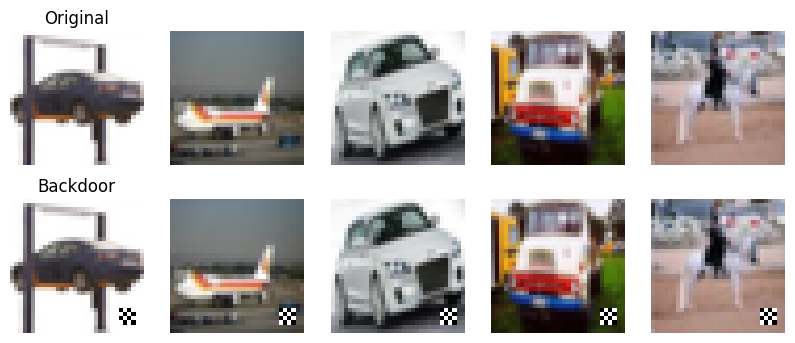

In [64]:
# Visualize some samples before and after crafting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(X_test[i].transpose(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(X_bdoor[i].transpose(1, 2, 0))
    axes[1, i].axis('off')
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Backdoor")
plt.show()

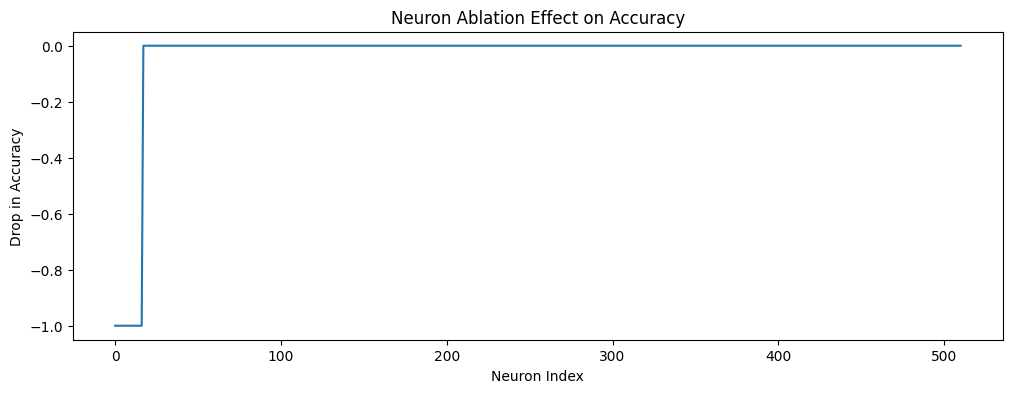

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("profile/activations/cifar10/ResNet18/base/neuron_ablations.checkerboard.csv")
df.columns = ['Layer', 'Neuron', 'DropInAcc', 'Before', 'After']

plt.figure(figsize=(12, 4))
plt.plot(df['DropInAcc'])
plt.title("Neuron Ablation Effect on Accuracy")
plt.xlabel("Neuron Index")
plt.ylabel("Drop in Accuracy")
plt.show()


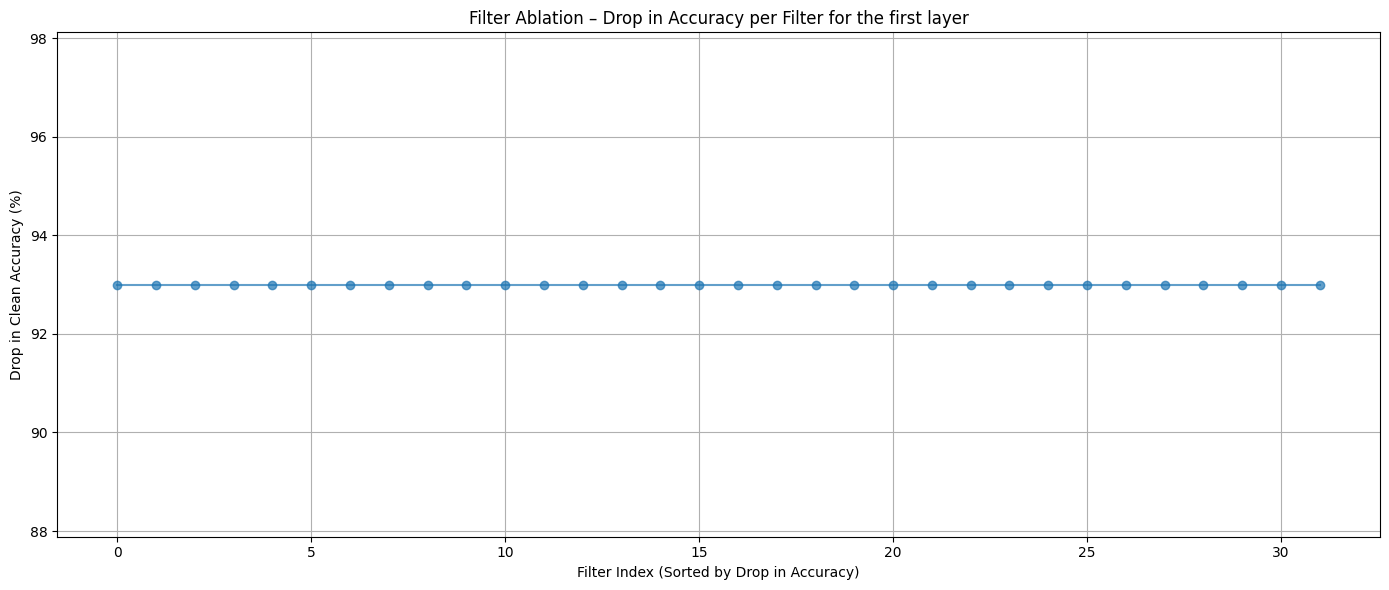

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace this with your actual path
csv_path = 'profile/activations/cifar10/ResNet18/base/filter_ablations.checkerboard.csv'

# Load the CSV
df = pd.read_csv(csv_path, header=None)
df.columns = ['Layer', 'FilterIdx', 'DropInAcc', 'CleanAcc', 'BackdoorAcc']

# Optional: sort by accuracy drop
df_sorted = df.sort_values(by='DropInAcc', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_sorted['DropInAcc'], marker='o', linestyle='-', alpha=0.7)
plt.title("Filter Ablation – Drop in Accuracy per Filter for the first layer")
plt.xlabel("Filter Index (Sorted by Drop in Accuracy)")
plt.ylabel("Drop in Clean Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Layer', y='DropInAcc')
plt.title("Filter Importance Distribution per Layer")
plt.xlabel("Layer Index")
plt.ylabel("Drop in Clean Accuracy (%)")
plt.tight_layout()
plt.show()

In [66]:
#inecting backdoors

In [22]:
# Evaluate backdoor attack success
bdoor_acc = valid('Backdoor', X_bdoor, Y_bdoor, num_batches, objax.Jit(lambda x: model(x, training=False), train_vars))
print(f'Backdoor Attack Accuracy: {bdoor_acc:.2f}%')
print('Handcrafted Backdoor Attack Phase Completed.')

   [valid-Backdoor]: 100%|██████████| 157/157 [00:21<00:00,  7.40it/s]

Backdoor Attack Accuracy: 85.68%
Handcrafted Backdoor Attack Phase Completed.


Starting CNN Profiling...
Activation profiles will be stored in: profile\activations\cifar10\ResNet18\base


   [profile-0]: 100%|██████████| 32/32 [30:00<00:00, 56.26s/it]

Filter ablations completed. 32 filters analyzed.


 : [profile-101]: 136it [2:17:02, 49.03s/it] 

## Evading Fine-Tuning Defense

In [24]:
batch_size = 50
# Evaluate model before fine-tuning
predict = objax.Jit(lambda x: model(x, training=False), model.vars())

acc_clean_before = valid('N/A', X_test, Y_test, batch_size, predict, silient=True)
acc_bdoor_before = valid('N/A', X_bdoor, Y_bdoor, batch_size, predict, silient=True)

print(f" Before Fine-Tuning:")
print(f"  - Clean Accuracy: {acc_clean_before:.2f}%")
print(f"  - Backdoor Success Rate: {acc_bdoor_before:.2f}%")


 Before Fine-Tuning:
  - Clean Accuracy: 87.47%
  - Backdoor Success Rate: 80.24%


In [26]:
batch_size = 50      
num_tunes = 5      
learning_rate = 0.025 
backdoor_label = 0   # Target label for backdoor
backdoor_size = 4    # Trigger size

# loss function
def loss_fn(x, y):
    logits = model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).mean()

# Define optimizer and gradient update
train_vars = objax.VarCollection(model.vars())
gv = objax.GradValues(loss_fn, train_vars)
optimizer = objax.optimizer.SGD(train_vars)

def fine_tune_step(x, y, lr):
    g, v = gv(x, y)
    optimizer(lr=lr, grads=g)
    return v

fine_tune_step = objax.Jit(fine_tune_step, gv.vars() + optimizer.vars())

In [27]:
# Run Fine-Tuning
for epoch in range(num_tunes):
    train_loss = train(epoch, X_train, Y_train, batch_size, fine_tune_step, learning_rate)
    
    acc_clean_after = valid('N/A', X_test, Y_test, batch_size, predict, silient=True)
    acc_bdoor_after = valid('N/A', X_bdoor, Y_bdoor, batch_size, predict, silient=True)

    print(f" Fine-Tune Epoch {epoch+1}/{num_tunes}")
    print(f"  - Clean Accuracy: {acc_clean_after:.2f}%")
    print(f"  - Backdoor Success Rate: {acc_bdoor_after:.2f}%")
    print(f"  - Training Loss: {train_loss:.4f}")

   [train-0]: 100%|██████████| 1000/1000 [21:53<00:00,  1.31s/it]


📌 Fine-Tune Epoch 1/5
  - Clean Accuracy: 91.90%
  - Backdoor Success Rate: 88.10%
  - Training Loss: 0.0510


   [train-1]: 100%|██████████| 1000/1000 [15:25<00:00,  1.08it/s]


📌 Fine-Tune Epoch 2/5
  - Clean Accuracy: 92.04%
  - Backdoor Success Rate: 87.53%
  - Training Loss: 0.0292


   [train-2]: 100%|██████████| 1000/1000 [09:44<00:00,  1.71it/s]


📌 Fine-Tune Epoch 3/5
  - Clean Accuracy: 91.90%
  - Backdoor Success Rate: 87.54%
  - Training Loss: 0.0146


   [train-3]: 100%|██████████| 1000/1000 [12:01<00:00,  1.39it/s]


📌 Fine-Tune Epoch 4/5
  - Clean Accuracy: 92.06%
  - Backdoor Success Rate: 86.88%
  - Training Loss: 0.0065


   [train-4]: 100%|██████████| 1000/1000 [18:15<00:00,  1.10s/it]


📌 Fine-Tune Epoch 5/5
  - Clean Accuracy: 92.05%
  - Backdoor Success Rate: 86.92%
  - Training Loss: 0.0029


In [34]:
# Save Fine-Tuned Model
save_path = f"models/{dataset}/{network}/fine_tuned_model_cifar10.npz"
save_network_parameters(model, save_path)
print(f"Fine-tuned model saved to {save_path}.")

Fine-tuned model saved to models/cifar10/ResNet18/fine_tuned_model_cifar10.npz.


### Evading Neural Cleanse: Visualization of Attack Success

In [ ]:
# Function to run Neural Cleanse and backdoor success evaluation
def run_neural_cleanse(a,b ,c):
    pass

def compute_nc_evasion_results(model, x_valid, y_valid, trigger_sizes):

    nc_detect_rates = []
    backdoor_success_rates = []

    for size in trigger_sizes:
        print(f"▶ Evaluating trigger size {size} pixels...")

        # Inject backdoor trigger and test attack success
        x_backdoor, y_backdoor = blend_backdoor(x_valid, y_valid, size)
        backdoor_success = valid('Backdoor', x_backdoor, y_backdoor, batch_size=50, predict=model)

        # Run Neural Cleanse to detect the backdoor
        nc_detect = run_neural_cleanse(a,b ,c )

        # Store results
        backdoor_success_rates.append(backdoor_success * 100)
        nc_detect_rates.append(nc_detect * 100)  

        print(f"  - Backdoor Success: {backdoor_success * 100:.2f}%")
        print(f"  - NC Detection Rate: {nc_detect * 100:.2f}%")

    return nc_detect_rates, backdoor_success_rates

# List of trigger sizes in pixels
_size_xaxis = [4, 8, 12, 16, 20, 24, 28]

# Compute results using your model
_size_ncres, _size_succs = compute_nc_evasion_results(model, x_valid, y_valid, _size_xaxis)

# Print final results
print("\nFinal Results:")
for i, size in enumerate(_size_xaxis):
    print(f"Trigger Size {size}: NC Detection { _size_ncres[i]}%, Backdoor Success {_size_succs[i]}%")


######################################################################################################
# Disable warnings for cleaner output
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set seaborn configurations for better visualization
_sns_configs = {
    'font.size': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
    'axes.labelsize': 16,
    'legend.facecolor': 'white',
    'legend.edgecolor': 'black',
    'legend.fontsize': 16,
    'grid.color': '#c0c0c0',
    'grid.linestyle': ':',
    'grid.linewidth': 0.8,
}
sns.set_theme(rc=_sns_configs)
#########################################################################################################
# Manually Collected Neural Cleanse (NC) Evasion Data
_size_xaxis = [4, 8, 12, 16, 20, 24, 28]  # Width of trigger patterns
_size_ncres = [100, 100, 10, 0, 0, 0, 0]  # Neural Cleanse detection rate (%)
_size_succs = [100, 100, 98, 100, 100, 100, 100]  # Backdoor success rate (%)

# Accuracy distribution based on trigger size
_size4_accs = [
    [0, 10, 20, 30, 40, 52, 61, 72, 89, 100],  # Backdoor success rate
    [0, 0, 0, 0, 0, 0, 60, 100, 100, 100],    # Neural Cleanse detection rate
]

_size8_accs = [
    [0, 10, 20, 30, 40, 50, 60, 70, 80, 93, 96, 98, 100],  # Backdoor success rate
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 60, 100],          # Neural Cleanse detection rate
]

_markers = ['o', 'v', 'p', '*', 'x']
_linestyles = [':', '-.', '--', '-']


# Create and Save Neural Cleanse Evasion Plots

# Set the storage directory
save_rdir = os.path.join("analysis", "NC")
os.makedirs(save_rdir, exist_ok=True)


# Plot 1: NC Detection Rate vs. Trigger Size
plt.figure(figsize=(9, 3.4))

sns.lineplot(
    x=np.array(_size_xaxis), y=np.array(_size_ncres),
    marker=_markers[0], markeredgecolor='r',
    linestyle=_linestyles[0], color='r', label='NC success'
)

sns.lineplot(
    x=np.array(_size_xaxis), y=np.array(_size_succs),
    marker=_markers[1], markeredgecolor='k',
    linestyle=_linestyles[1], color='k', label='Backdoor success'
)

plt.xlim(min(_size_xaxis), max(_size_xaxis))
plt.xticks(_size_xaxis + [4.])
plt.xlabel("Trigger Pattern Width (pixels)")
plt.ylim(-1, 101)
plt.yticks(range(0, 120, 20))
plt.ylabel("NC Detection Rate (%)")
plt.legend()

plot_filename = os.path.join(save_rdir, "nc_detection_vs_trigger_size.png")
plt.tight_layout()
plt.savefig(plot_filename)
plt.show()

print(" Plot 1: NC Detection Rate vs. Trigger Size saved successfully.")


# Plot 2: Backdoor Success Rate vs. NC Detection
plt.figure(figsize=(9, 3.4))

sns.lineplot(
    x=np.array(_size4_accs[0]), y=np.array(_size4_accs[1]),
    marker=_markers[0], markeredgecolor='b',
    linestyle=_linestyles[0], color='b', label="4x4 Trigger"
)

sns.lineplot(
    x=np.array(_size8_accs[0]), y=np.array(_size8_accs[1]),
    marker=_markers[1], markeredgecolor='k',
    linestyle=_linestyles[1], color='k', label="8x8 Trigger"
)

plt.xlim(0, 100)
plt.xlabel("Backdoor Success Rate (%)")
plt.ylim(-1, 101)
plt.yticks(range(20, 120, 20))
plt.ylabel("NC Detection Rate (%)")
plt.legend(loc="upper left")

plot_filename = os.path.join(save_rdir, "nc_detection_vs_success_rate.png")
plt.tight_layout()
plt.savefig(plot_filename)
plt.show()

print("Plot 2: Backdoor Success Rate vs. NC Detection saved successfully.")

# Completed
print("Neural Cleanse evasion plots generated successfully!")
